In [40]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
import seaborn as sns
import joblib

In [41]:
center_trace = joblib.load("../../data/center_trace.pkl")
left_trace = joblib.load("../../data/left_trace.pkl")
right_trace = joblib.load("../../data/right_trace.pkl")
race_trace = joblib.load("../../data/race_trace.pkl")

In [42]:
center_trace

[{'ego_x': 1.0074688571484969,
  'ego_y': 25.205744570466997,
  'ego_theta': 0.03615169009874174,
  'ego_vel': 0.8986949999999999,
  'opp_x': -2.4249911097625088,
  'opp_y': 25.11835391447974,
  'opp_theta': 0.022967673816288406,
  'opp_vel': 0.894155086235624,
  'selected_lane': 'center'},
 {'ego_x': 1.136938095748206,
  'ego_y': 25.233845268940936,
  'ego_theta': 0.1518755338048503,
  'ego_vel': 1.8496949999999996,
  'opp_x': -2.2928297680489202,
  'opp_y': 25.121927677820903,
  'opp_theta': 0.024268179968554484,
  'opp_vel': 1.8451550862356236,
  'selected_lane': 'center'},
 {'ego_x': 1.348307869114793,
  'ego_y': 25.317945171032925,
  'ego_theta': 0.3692124595854942,
  'ego_vel': 2.785250678861465,
  'opp_x': -2.068059137275857,
  'opp_y': 25.12590313919464,
  'opp_theta': 0.01876730943156893,
  'opp_vel': 2.6779196594628405,
  'selected_lane': 'center'},
 {'ego_x': 1.6238937966170421,
  'ego_y': 25.461832685372777,
  'ego_theta': 0.502559050751457,
  'ego_vel': 3.446529203389014,


In [43]:
dataset = list()

In [44]:
for trace in [center_trace, left_trace, right_trace, race_trace]:
    for i in range(5, (len(trace)-90)//10):
        dataset.append({
            'input': np.array([[trace[idx]['opp_x'], trace[idx]['opp_y'], trace[idx]['opp_theta']] for idx in range(i*10,(i*10)+10)]),
            'target': np.array([[trace[idx]['opp_x'], trace[idx]['opp_y'], trace[idx]['opp_theta']] for idx in range((i*10)+10,(i+1)*10+80)]),
            'selected_lane': trace[0]['selected_lane']
        })

In [45]:
dataset

[{'input': array([[16.25988538, 25.7805131 ,  0.06096444],
         [16.51748743, 25.74163331,  6.00592872],
         [16.74796433, 25.64282309,  5.81319685],
         [16.96302458, 25.5275572 ,  5.78216514],
         [17.16988021, 25.41317759,  5.77753697],
         [17.37139329, 25.30342948,  5.78270721],
         [17.56864511, 25.19550275,  5.78416738],
         [17.76107286, 25.08873797,  5.77454903],
         [17.95002925, 24.98239424,  5.76566242],
         [18.1345151 , 24.8726922 ,  5.74637792]]),
  'target': array([[18.31387083, 24.75879705,  5.7137387 ],
         [18.48981121, 24.64178274,  5.69353951],
         [18.65989033, 24.51879443,  5.65464108],
         [18.82504978, 24.39151131,  5.61981584],
         [18.98377865, 24.25744931,  5.58050473],
         [19.13603715, 24.1175493 ,  5.53441982],
         [19.28227307, 23.97201124,  5.49454135],
         [19.42106933, 23.82001727,  5.45110517],
         [19.55450795, 23.66353407,  5.41286061],
         [19.6815323 , 23.501

In [46]:
dataset_frame = pd.DataFrame(dataset)

In [47]:
dataset_frame

,input,target,selected_lane
0,"[[16.259885377356373, 25.78051310217524, 0.060...","[[18.313870828301084, 24.75879705273728, 5.713...",center
1,"[[18.313870828301084, 24.75879705273728, 5.713...","[[19.80369533019667, 23.335834630561155, 5.339...",center
2,"[[19.80369533019667, 23.335834630561155, 5.339...","[[20.72157620584647, 21.255479754727283, 4.977...",center
3,"[[20.72157620584647, 21.255479754727283, 4.977...","[[21.588063720838058, 18.062197117668557, 5.01...",center
4,"[[21.588063720838058, 18.062197117668557, 5.01...","[[22.697047133084446, 14.31920690722272, 4.996...",center
...,...,...,...
583,"[[20.465647939696872, 21.652932828209227, 5.36...","[[22.44190887701588, 18.1333502030073, 5.07008...",race
584,"[[22.44190887701588, 18.1333502030073, 5.07008...","[[23.46396701043118, 14.223841061347542, 4.837...",race
585,"[[23.46396701043118, 14.223841061347542, 4.837...","[[23.24526582535912, 10.207689360235248, 4.426...",race
586,"[[23.24526582535912, 10.207689360235248, 4.426...","[[21.18409559457932, 6.775538464036721, 3.9108...",race


In [48]:
dataset_frame.iloc[0]['input'][:,1]

array([25.7805131 , 25.74163331, 25.64282309, 25.5275572 , 25.41317759,
       25.30342948, 25.19550275, 25.08873797, 24.98239424, 24.8726922 ])

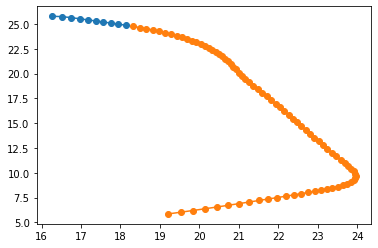

In [49]:
DATA_IDX = 0
plt.plot(dataset_frame.iloc[DATA_IDX]['input'][:,0], dataset_frame.iloc[DATA_IDX]['input'][:,1], marker='o')
plt.plot(dataset_frame.iloc[DATA_IDX]['target'][:,0], dataset_frame.iloc[DATA_IDX]['target'][:,1], marker='o')

In [50]:
dataset_frame.to_pickle("../../data/final_data.pkl")

In [51]:
from sklearn.model_selection import train_test_split
TEST_FRAC = 0.2
classes = dataset_frame['selected_lane']
train_frame, test_frame = train_test_split(dataset_frame,stratify=classes, test_size=TEST_FRAC)

In [52]:
train_frame.groupby(['selected_lane']).count()

,input,target
selected_lane,,
center,117,117
left,118,118
race,117,117
right,118,118


In [53]:
test_frame.groupby(['selected_lane']).count()

,input,target
selected_lane,,
center,30,30
left,29,29
race,30,30
right,29,29


In [54]:
train_frame.to_pickle("../../data/train_data.pkl")
test_frame.to_pickle("../../data/test_data.pkl")